<a href="https://colab.research.google.com/github/smartaces/Anthropic_Claude_Sonnet_3_7_extended_thinking_colab_quickstart_notebook/blob/main/Anthropic_Claude_Sonnet_Extended_Thinking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sonnet 3.7 Extended Thinking Quickstart Notebook**

This is a quick notebook to help you start experimenting with and learning about how to build with Sonnet 3.7

Important:

*   I did not write this code, I merely consolidated it into a Colab notebook to help make it a little more accessible for some to get up and running testing Sonnet 3.7

*   The code for this notebook was obtained from the Anthropic cookbook library, you can find the original code here: https://github.com/anthropics/anthropic-cookbook/tree/main/extended_thinking

*   There are quite a few nuances to Sonnet 3.7 to begin learning about. As per the below evals, it's a pretty darn good coder.

It is also Anthropic's first reasoning model, and as a result introduces some new functionality like 'thinking blocks', redacted_thinking and cryptographic tokens.

For more information on all of these I highly recommend that in addition to testing the below examples, you also check out the documentation here: https://docs.anthropic.com/en/docs/build-with-claude/extended-thinking#how-extended-thinking-works

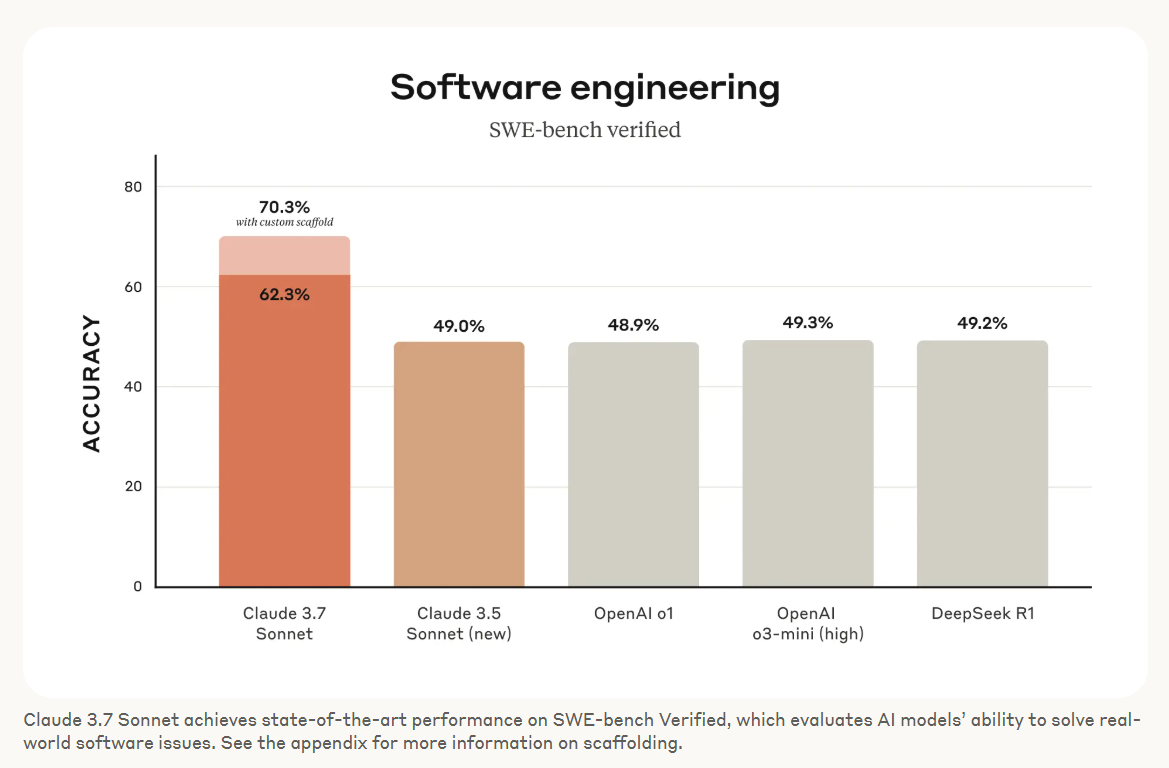

# **Connect with Me**

*   If you like this notebook or in any way found it helpful, feel free to connect with me on LinkedIn here: https://www.linkedin.com/in/james-bentley-1b329214/

# **Add In Your Anthropic API Key**

To use this notebook and build your solution you will need...


*   An Anthropic user account and API Key (with billing set up)
*   As pictured below add this to your Google Secrets (see the key icon on the left panel) inserting your key in the 'value' field and assigning the following name
*   Key name: claude_api
*   Once that is done, run the below cell[link text granting key access to the notebook access if prompted

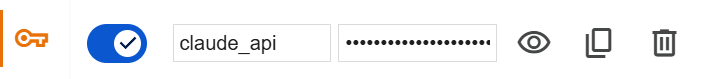

# **Step 1: Install the Anthropic python library**

First we need to install the OpenAI python Library and respective files from the OpenAI swarms github.

In [1]:
#installs
!pip install anthropic --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.5/239.5 kB 5.1 MB/s eta 0:00:00


# **Step 2: Set Your Anthropic Key**

First we need to install the OpenAI python Library and respective files from the OpenAI swarms github.

In [2]:
import os
from google.colab import userdata
from anthropic import Anthropic

# Retrieve API keys from Google Colab Secrets
claude_key = userdata.get('claude_api')

os.environ["ANTHROPIC_API_KEY"] = claude_key

# Initialize clients
client = Anthropic(api_key=claude_key)

In [3]:
import anthropic
import os

# Helper functions
def print_thinking_response(response):
    """Pretty print a message response with thinking blocks."""
    print("\n==== FULL RESPONSE ====")
    for block in response.content:
        if block.type == "thinking":
            print("\n🧠 THINKING BLOCK:")
            # Show truncated thinking for readability
            print(block.thinking[:500] + "..." if len(block.thinking) > 500 else block.thinking)
            print(f"\n[Signature available: {bool(getattr(block, 'signature', None))}]")
            if hasattr(block, 'signature') and block.signature:
                print(f"[Signature (first 50 chars): {block.signature[:50]}...]")
        elif block.type == "redacted_thinking":
            print("\n🔒 REDACTED THINKING BLOCK:")
            print(f"[Data length: {len(block.data) if hasattr(block, 'data') else 'N/A'}]")
        elif block.type == "text":
            print("\n✓ FINAL ANSWER:")
            print(block.text)

    print("\n==== END RESPONSE ====")

def count_tokens(messages):
    """Count tokens for a given message list."""
    result = client.messages.count_tokens(
        model="claude-3-7-sonnet-20250219",
        messages=messages
    )
    return result.input_tokens

# **Basic example**
Extended thinking in action:

In [4]:
def basic_thinking_example():
    response = client.messages.create(
        model="claude-3-7-sonnet-20250219",
        max_tokens=4000,
        thinking= {
            "type": "enabled",
            "budget_tokens": 2000
        },
        messages=[{
            "role": "user",
            "content": "Solve this puzzle: Three people check into a hotel. They pay $30 to the manager. The manager finds out that the room only costs $25 so he gives $5 to the bellboy to return to the three people. The bellboy, however, decides to keep $2 and gives $1 back to each person. Now, each person paid $10 and got back $1, so they paid $9 each, totaling $27. The bellboy kept $2, which makes $29. Where is the missing $1?"
        }]
    )

    print_thinking_response(response)

basic_thinking_example()


==== FULL RESPONSE ====

🧠 THINKING BLOCK:
Let's think about this step by step. 

Initially:
- Three people pay $30 total ($10 each)
- The room actually costs $25
- The manager gives $5 to the bellboy to return to the guests

What happens:
- The bellboy keeps $2 for himself
- The bellboy gives $1 back to each person (total of $3 returned)

So the actual flow of money is:
- Guests pay $30 initially
- Manager keeps $25 for the room
- Bellboy keeps $2
- Guests get back $3 (or $1 each)

Let's check: $25 + $2 + $3 = $30. This accounts for all...

[Signature available: True]
[Signature (first 50 chars): EuYBCkQYAiJAUa6QO8yhOeRQKAYDzel28mvT0pFFwrXegEEu4X...]

✓ FINAL ANSWER:
# Hotel Check-in Puzzle Solution

This puzzle uses a deceptive way of accounting that creates a false paradox. Let's break down what actually happens:

## The Correct Accounting

1. Guests initially pay $30
2. Manager keeps $25 for the room
3. Bellboy keeps $2
4. Guests receive $3 back ($1 each)

So: $25 + $2 + $3 = $30 

# **Streaming with extended thinking**
This example shows how to handle streaming with thinking:

In [5]:
def streaming_with_thinking():
    with client.messages.stream(
        model="claude-3-7-sonnet-20250219",
        max_tokens=4000,
        thinking={
            "type": "enabled",
            "budget_tokens": 2000
        },
        messages=[{
            "role": "user",
            "content": "Solve this puzzle: Three people check into a hotel. They pay $30 to the manager. The manager finds out that the room only costs $25 so he gives $5 to the bellboy to return to the three people. The bellboy, however, decides to keep $2 and gives $1 back to each person. Now, each person paid $10 and got back $1, so they paid $9 each, totaling $27. The bellboy kept $2, which makes $29. Where is the missing $1?"
        }]
    ) as stream:
        # Track what we're currently building
        current_block_type = None
        current_content = ""

        for event in stream:
            if event.type == "content_block_start":
                current_block_type = event.content_block.type
                print(f"\n--- Starting {current_block_type} block ---")
                current_content = ""

            elif event.type == "content_block_delta":
                if event.delta.type == "thinking_delta":
                    print(event.delta.thinking, end="", flush=True)  # Just print dots for thinking to avoid clutter
                    current_content += event.delta.thinking
                elif event.delta.type == "text_delta":
                    print(event.delta.text, end="", flush=True)
                    current_content += event.delta.text

            elif event.type == "content_block_stop":
                if current_block_type == "thinking":
                    # Just show a summary for thinking
                    print(f"\n[Completed thinking block, {len(current_content)} characters]")
                elif current_block_type == "redacted_thinking":
                    print("\n[Redacted thinking block]")
                print(f"--- Finished {current_block_type} block ---\n")
                current_block_type = None

            elif event.type == "message_stop":
                print("\n--- Message complete ---")

streaming_with_thinking()


--- Starting thinking block ---
Let's first trace through the money step by step:

1. Three people pay $30 total ($10 each) to the manager.
2. The manager keeps $25 for the room.
3. The manager gives $5 to the bellboy.
4. The bellboy keeps $2 and returns $3 to the guests ($1 each).

So let's account for all the money:
- The manager has $25
- The bellboy has $2
- The three guests got back $3 total ($1 each)

$25 + $2 + $3 = $30

So all the money is accounted for. There is no missing dollar.

The confusion in the puzzle arises from mixing two different ways of accounting:

When we say "each person paid $9 each, totaling $27", we're looking at the net amount paid by the guests.
When we add "The bellboy kept $2, which makes $29", we're incorrectly adding the bellboy's $2 to the guests' payment.

The correct way to look at it is:
- The guests paid a net amount of $27 ($9 each)
- The hotel received $25
- The bellboy received $2

$27 = $25 + $2

So there's no missing dollar. The confusion co

# **Single tool calls with thinking**
This example demonstrates how to combine thinking and make a single tool call, with a mock weather tool.

In [6]:
# Global variables for model and token budgets
MODEL_NAME = "claude-3-7-sonnet-20250219"
MAX_TOKENS = 4000
THINKING_BUDGET_TOKENS = 2000

In [7]:
import anthropic
import os
import json
def tool_use_with_thinking():
    # Define a weather tool
    tools = [
        {
            "name": "weather",
            "description": "Get current weather information for a location.",
            "input_schema": {
                "type": "object",
                "properties": {
                    "location": {
                        "type": "string",
                        "description": "The location to get weather for."
                    }
                },
                "required": ["location"]
            }
        }
    ]

    def weather(location):
        # Mock weather data
        weather_data = {
            "New York": {"temperature": 72, "condition": "Sunny"},
            "London": {"temperature": 62, "condition": "Cloudy"},
            "Tokyo": {"temperature": 80, "condition": "Partly cloudy"},
            "Paris": {"temperature": 65, "condition": "Rainy"},
            "Sydney": {"temperature": 85, "condition": "Clear"},
            "Berlin": {"temperature": 60, "condition": "Foggy"},
        }

        return weather_data.get(location, {"error": f"No weather data available for {location}"})

    # Initial request with tool use and thinking
    response = client.messages.create(
        model=MODEL_NAME,
        max_tokens=MAX_TOKENS,
        thinking={
            "type": "enabled",
            "budget_tokens": THINKING_BUDGET_TOKENS
        },
        tools=tools,
        messages=[{
            "role": "user",
            "content": "What's the weather like in Paris today?"
        }]
    )

    # Detailed diagnostic output of initial response
    print("\n=== INITIAL RESPONSE ===")
    print(f"Response ID: {response.id}")
    print(f"Stop reason: {response.stop_reason}")
    print(f"Model: {response.model}")
    print(f"Content blocks: {len(response.content)} blocks")

    for i, block in enumerate(response.content):
        print(f"\nBlock {i+1}: Type = {block.type}")
        if block.type == "thinking":
            print(f"Thinking content: {block.thinking[:150]}...")
            print(f"Signature available: {bool(getattr(block, 'signature', None))}")
        elif block.type == "text":
            print(f"Text content: {block.text}")
        elif block.type == "tool_use":
            print(f"Tool: {block.name}")
            print(f"Tool input: {block.input}")
            print(f"Tool ID: {block.id}")
    print("=== END INITIAL RESPONSE ===\n")

    # Extract thinking blocks to include in the conversation history
    assistant_blocks = []
    for block in response.content:
        if block.type in ["thinking", "redacted_thinking", "tool_use"]:
            assistant_blocks.append(block)

    # Handle tool use if required
    full_conversation = [{
        "role": "user",
        "content": "What's the weather like in Paris today?"
    }]

    if response.stop_reason == "tool_use":
        # Add entire assistant response with thinking blocks and tool use
        full_conversation.append({
            "role": "assistant",
            "content": assistant_blocks
        })

        # Find the tool_use block
        tool_use_block = next((block for block in response.content if block.type == "tool_use"), None)
        if tool_use_block:
            # Execute the tool
            print(f"\n=== EXECUTING TOOL ===")
            print(f"Tool name: {tool_use_block.name}")
            print(f"Location to check: {tool_use_block.input['location']}")
            tool_result = weather(tool_use_block.input["location"])
            print(f"Result: {tool_result}")
            print("=== TOOL EXECUTION COMPLETE ===\n")

            # Add tool result to conversation
            full_conversation.append({
                "role": "user",
                "content": [{
                    "type": "tool_result",
                    "tool_use_id": tool_use_block.id,
                    "content": json.dumps(tool_result)
                }]
            })

            # Continue the conversation with the same thinking configuration
            print("\n=== SENDING FOLLOW-UP REQUEST WITH TOOL RESULT ===")
            response = client.messages.create(
                model=MODEL_NAME,
                max_tokens=MAX_TOKENS,
                thinking={
                    "type": "enabled",
                    "budget_tokens": THINKING_BUDGET_TOKENS
                },
                tools=tools,
                messages=full_conversation
            )
            print(f"Follow-up response received. Stop reason: {response.stop_reason}")

    print_thinking_response(response)

# Run the example
tool_use_with_thinking()


=== INITIAL RESPONSE ===
Response ID: msg_015bmZhtAPon6ZE5a8u5sA33
Stop reason: tool_use
Model: claude-3-7-sonnet-20250219
Content blocks: 3 blocks

Block 1: Type = thinking
Thinking content: The user is asking about the current weather in Paris. I have access to a weather function that can provide this information.

Let me check the requir...
Signature available: True

Block 2: Type = text
Text content: I'll check the current weather in Paris for you.

Block 3: Type = tool_use
Tool: weather
Tool input: {'location': 'Paris'}
Tool ID: toolu_01WGEn1RLApYMcfFFEa9ZtE4
=== END INITIAL RESPONSE ===


=== EXECUTING TOOL ===
Tool name: weather
Location to check: Paris
Result: {'temperature': 65, 'condition': 'Rainy'}
=== TOOL EXECUTION COMPLETE ===


=== SENDING FOLLOW-UP REQUEST WITH TOOL RESULT ===
Follow-up response received. Stop reason: end_turn

==== FULL RESPONSE ====

✓ FINAL ANSWER:
The current weather in Paris is rainy with a temperature of 65°F.

==== END RESPONSE ====


# **Multiple tool calls with thinking**
This example demonstrates how to handle multiple tool calls, such as a mock news and weather service, while observing the thinking process.

In [8]:
def multiple_tool_calls_with_thinking():
    # Define tools
    tools = [
        {
            "name": "weather",
            "description": "Get current weather information for a location.",
            "input_schema": {
                "type": "object",
                "properties": {
                    "location": {
                        "type": "string",
                        "description": "The location to get weather for."
                    }
                },
                "required": ["location"]
            }
        },
        {
            "name": "news",
            "description": "Get latest news headlines for a topic.",
            "input_schema": {
                "type": "object",
                "properties": {
                    "topic": {
                        "type": "string",
                        "description": "The topic to get news about."
                    }
                },
                "required": ["topic"]
            }
        }
    ]

    def weather(location):
        # Mock weather data
        weather_data = {
            "New York": {"temperature": 72, "condition": "Sunny"},
            "London": {"temperature": 62, "condition": "Cloudy"},
            "Tokyo": {"temperature": 80, "condition": "Partly cloudy"},
            "Paris": {"temperature": 65, "condition": "Rainy"},
            "Sydney": {"temperature": 85, "condition": "Clear"},
            "Berlin": {"temperature": 60, "condition": "Foggy"},
        }

        return weather_data.get(location, {"error": f"No weather data available for {location}"})

    def news(topic):
        # Mock news data
        news_data = {
            "technology": [
                "New AI breakthrough announced by research lab",
                "Tech company releases latest smartphone model",
                "Quantum computing reaches milestone achievement"
            ],
            "sports": [
                "Local team wins championship game",
                "Star player signs record-breaking contract",
                "Olympic committee announces host city for 2036"
            ],
            "weather": [
                "Storm system developing in the Atlantic",
                "Record temperatures recorded across Europe",
                "Climate scientists release new research findings"
            ]
        }

        return {"headlines": news_data.get(topic.lower(), ["No news available for this topic"])}

    # Initial request
    response = client.messages.create(
        model=MODEL_NAME,
        max_tokens=MAX_TOKENS,
        thinking={
                "type": "enabled",
                "budget_tokens": THINKING_BUDGET_TOKENS
        },
        tools=tools,
        messages=[{
            "role": "user",
            "content": "What's the weather in London, and can you also tell me the latest news about technology?"
        }]
    )

    # Print detailed information about initial response
    print("\n=== INITIAL RESPONSE ===")
    print(f"Response ID: {response.id}")
    print(f"Stop reason: {response.stop_reason}")
    print(f"Model: {response.model}")
    print(f"Content blocks: {len(response.content)} blocks")

    # Print each content block
    for i, block in enumerate(response.content):
        print(f"\nBlock {i+1}: Type = {block.type}")
        if block.type == "thinking":
            print(f"Thinking content: {block.thinking[:150]}...")
            print(f"Signature available: {bool(getattr(block, 'signature', None))}")
        elif block.type == "text":
            print(f"Text content: {block.text}")
        elif block.type == "tool_use":
            print(f"Tool: {block.name}")
            print(f"Tool input: {block.input}")
            print(f"Tool ID: {block.id}")
    print("=== END INITIAL RESPONSE ===\n")

    # Handle potentially multiple tool calls
    full_conversation = [{
        "role": "user",
        "content": "What's the weather in London, and can you also tell me the latest news about technology?"
    }]

    # Track iteration count for multi-turn tool use
    iteration = 0

    while response.stop_reason == "tool_use":
        iteration += 1
        print(f"\n=== TOOL USE ITERATION {iteration} ===")

        # Extract thinking blocks and tool use to include in conversation history
        assistant_blocks = []
        for block in response.content:
            if block.type in ["thinking", "redacted_thinking", "tool_use"]:
                assistant_blocks.append(block)

        # Add assistant response with thinking blocks and tool use
        full_conversation.append({
            "role": "assistant",
            "content": assistant_blocks
        })

        # Find the tool_use block
        tool_use_block = next((block for block in response.content if block.type == "tool_use"), None)
        if tool_use_block:
            print(f"\n=== EXECUTING TOOL ===")
            print(f"Tool name: {tool_use_block.name}")

            # Execute the appropriate tool
            if tool_use_block.name == "weather":
                print(f"Location to check: {tool_use_block.input['location']}")
                tool_result = weather(tool_use_block.input["location"])
            elif tool_use_block.name == "news":
                print(f"Topic to check: {tool_use_block.input['topic']}")
                tool_result = news(tool_use_block.input["topic"])
            else:
                tool_result = {"error": "Unknown tool"}

            print(f"Result: {tool_result}")
            print("=== TOOL EXECUTION COMPLETE ===\n")

            # Add tool result to conversation
            full_conversation.append({
                "role": "user",
                "content": [{
                    "type": "tool_result",
                    "tool_use_id": tool_use_block.id,
                    "content": json.dumps(tool_result)
                }]
            })

            # Continue the conversation
            print("\n=== SENDING FOLLOW-UP REQUEST WITH TOOL RESULT ===")
            response = client.messages.create(
                model=MODEL_NAME,
                max_tokens=MAX_TOKENS,
                thinking={
                        "type": "enabled",
                        "budget_tokens": THINKING_BUDGET_TOKENS
                },
                tools=tools,
                messages=full_conversation
            )

            # Print follow-up response details
            print(f"\n=== FOLLOW-UP RESPONSE (ITERATION {iteration}) ===")
            print(f"Response ID: {response.id}")
            print(f"Stop reason: {response.stop_reason}")
            print(f"Content blocks: {len(response.content)} blocks")

            for i, block in enumerate(response.content):
                print(f"\nBlock {i+1}: Type = {block.type}")
                if block.type == "thinking":
                    print(f"Thinking content preview: {block.thinking[:100]}...")
                elif block.type == "text":
                    print(f"Text content preview: {block.text[:100]}...")
                elif block.type == "tool_use":
                    print(f"Tool: {block.name}")
                    print(f"Tool input preview: {str(block.input)[:100]}")
            print(f"=== END FOLLOW-UP RESPONSE (ITERATION {iteration}) ===\n")

            if response.stop_reason != "tool_use":
                print("\n=== FINAL RESPONSE ===")
                print_thinking_response(response)
                print("=== END FINAL RESPONSE ===")
        else:
            print("No tool_use block found in response.")
            break

# Run the example
multiple_tool_calls_with_thinking()


=== INITIAL RESPONSE ===
Response ID: msg_019KiHJHvEbuhRFsK1wSmRZQ
Stop reason: tool_use
Model: claude-3-7-sonnet-20250219
Content blocks: 3 blocks

Block 1: Type = thinking
Thinking content: Let me analyze the user's request:

1. "What's the weather in London" - This requires using the weather function
   - Parameter needed: location = "Lo...
Signature available: True

Block 2: Type = text
Text content: I'll get that information for you right away.

Block 3: Type = tool_use
Tool: weather
Tool input: {'location': 'London'}
Tool ID: toolu_012ZfGdokk3tDRtFeY8SwBX3
=== END INITIAL RESPONSE ===


=== TOOL USE ITERATION 1 ===

=== EXECUTING TOOL ===
Tool name: weather
Location to check: London
Result: {'temperature': 62, 'condition': 'Cloudy'}
=== TOOL EXECUTION COMPLETE ===


=== SENDING FOLLOW-UP REQUEST WITH TOOL RESULT ===

=== FOLLOW-UP RESPONSE (ITERATION 1) ===
Response ID: msg_012NQjX6GL4BLF1xAG51Pk4j
Stop reason: tool_use
Content blocks: 1 blocks

Block 1: Type = tool_use
Tool: ne

# **Preserving thinking blocks**
When working with extended thinking and tools, make sure to:

Preserve thinking block signatures: Each thinking block contains a cryptographic signature that validates the conversation context. These signatures must be included when passing thinking blocks back to Claude.

Avoid modifying prior context: The API will reject requests if any previous content (including thinking blocks) is modified when submitting a new request with tool results.

Handle both thinking and redacted_thinking blocks: Both types of blocks must be preserved in the conversation history, even if the content of redacted blocks is not human readable.

For more details on extended thinking without tools, see the main "Extended Thinking" notebook.

In [9]:
def thinking_block_preservation_example():
    # Define a simple weather tool
    tools = [
        {
            "name": "weather",
            "description": "Get current weather information for a location.",
            "input_schema": {
                "type": "object",
                "properties": {
                    "location": {
                        "type": "string",
                        "description": "The location to get weather for."
                    }
                },
                "required": ["location"]
            }
        }
    ]

    def weather(location):
        # Mock weather data
        weather_data = {
            "New York": {"temperature": 72, "condition": "Sunny"},
            "London": {"temperature": 62, "condition": "Cloudy"},
            "Tokyo": {"temperature": 80, "condition": "Partly cloudy"},
            "Paris": {"temperature": 65, "condition": "Rainy"},
            "Sydney": {"temperature": 85, "condition": "Clear"},
            "Berlin": {"temperature": 60, "condition": "Foggy"},
        }

        return weather_data.get(location, {"error": f"No weather data available for {location}"})

    # Initial request with tool use and thinking
    response = client.messages.create(
        model=MODEL_NAME,
        max_tokens=MAX_TOKENS,
        thinking={
            "type": "enabled",
            "budget_tokens": THINKING_BUDGET_TOKENS
        },
        tools=tools,
        messages=[{
            "role": "user",
            "content": "What's the weather like in Berlin right now?"
        }]
    )

    # Extract blocks from response
    thinking_blocks = [b for b in response.content if b.type == "thinking"]
    tool_use_blocks = [b for b in response.content if b.type == "tool_use"]

    print("\n=== INITIAL RESPONSE ===")
    print(f"Response contains:")
    print(f"- {len(thinking_blocks)} thinking blocks")
    print(f"- {len(tool_use_blocks)} tool use blocks")

    # Check if tool use was triggered
    if tool_use_blocks:
        tool_block = tool_use_blocks[0]
        print(f"\nTool called: {tool_block.name}")
        print(f"Location to check: {tool_block.input['location']}")

        # Execute the tool
        tool_result = weather(tool_block.input["location"])
        print(f"Tool result: {tool_result}")

        # First, let's try WITHOUT including the thinking block
        print("\n=== TEST 1: WITHOUT thinking block ===")
        try:
            # Notice we're only including the tool_use block, not the thinking block
            partial_blocks = tool_use_blocks

            incomplete_response = client.messages.create(
                model=MODEL_NAME,
                max_tokens=MAX_TOKENS,
                thinking={
                        "type": "enabled",
                        "budget_tokens": THINKING_BUDGET_TOKENS
                },
                tools=tools,
                messages=[
                    {"role": "user", "content": "What's the weather like in Berlin right now?"},
                    {"role": "assistant", "content": partial_blocks},
                    {"role": "user", "content": [{
                        "type": "tool_result",
                        "tool_use_id": tool_block.id,
                        "content": json.dumps(tool_result)
                    }]}
                ]
            )
            print("SUCCESS: Response received without thinking block (not expected)")
        except Exception as e:
            print(f"ERROR: {e}")
            print("This demonstrates that thinking blocks must be preserved")

        # Now try WITH the thinking block included (correct approach)
        print("\n=== TEST 2: WITH thinking block (correct approach) ===")
        try:
            # Include all blocks from the response
            complete_blocks = thinking_blocks + tool_use_blocks

            complete_response = client.messages.create(
                model=MODEL_NAME,
                max_tokens=MAX_TOKENS,
                thinking={
                    "type": "enabled",
                    "budget_tokens": THINKING_BUDGET_TOKENS
                },
                tools=tools,
                messages=[
                    {"role": "user", "content": "What's the weather like in Berlin right now?"},
                    {"role": "assistant", "content": complete_blocks},
                    {"role": "user", "content": [{
                        "type": "tool_result",
                        "tool_use_id": tool_block.id,
                        "content": json.dumps(tool_result)
                    }]}
                ]
            )
            print("SUCCESS: Response received with thinking blocks included")

            # Check if second response has thinking blocks
            second_thinking = [b for b in complete_response.content if b.type == "thinking"]
            second_text = [b for b in complete_response.content if b.type == "text"]

            print(f"\nSecond response contains:")
            print(f"- {len(second_thinking)} thinking blocks")
            print(f"- {len(second_text)} text blocks")

            if second_text:
                print(f"\nFinal answer: {second_text[0].text}")

            print("\nNote: The second response after tool use doesn't contain thinking blocks.")
            print("This is expected behavior - thinking is shown before tool use but not after receiving tool results.")

        except Exception as e:
            print(f"ERROR: {e}")

# Uncomment to run the example
thinking_block_preservation_example()


=== INITIAL RESPONSE ===
Response contains:
- 1 thinking blocks
- 1 tool use blocks

Tool called: weather
Location to check: Berlin
Tool result: {'temperature': 60, 'condition': 'Foggy'}

=== TEST 1: WITHOUT thinking block ===
ERROR: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.1.content.0.type: Expected `thinking` or `redacted_thinking`, but found `tool_use`. When `thinking` is enabled, a final `assistant` message must start with a thinking block (preceeding the lastmost set of `tool_use` and `tool_result` blocks). We recommend you include thinking blocks from previous turns. To avoid this requirement, disable `thinking`. Please consult our documentation at https://docs.anthropic.com/en/docs/build-with-claude/extended-thinking'}}
This demonstrates that thinking blocks must be preserved

=== TEST 2: WITH thinking block (correct approach) ===
SUCCESS: Response received with thinking blocks included

Second response contains:
- 0 th

# **Token counting and context window management**
This example demonstrates how to track token usage with extended thinking:

In [10]:
def token_counting_example():
    # Define a function to create a sample prompt
    def create_sample_messages():
        messages = [{
            "role": "user",
            "content": "Solve this puzzle: Three people check into a hotel. They pay $30 to the manager. The manager finds out that the room only costs $25 so he gives $5 to the bellboy to return to the three people. The bellboy, however, decides to keep $2 and gives $1 back to each person. Now, each person paid $10 and got back $1, so they paid $9 each, totaling $27. The bellboy kept $2, which makes $29. Where is the missing $1?"
        }]
        return messages

    # Count tokens without thinking
    base_messages = create_sample_messages()
    base_token_count = count_tokens(base_messages)
    print(f"Base token count (input only): {base_token_count}")

    # Make a request with thinking and check actual usage
    response = client.messages.create(
        model="claude-3-7-sonnet-20250219",
        max_tokens=8000,
        thinking = {
            "type": "enabled",
            "budget_tokens": 2000
        },
        messages=base_messages
    )

    # Calculate and print token usage stats
    thinking_tokens = sum(
        len(block.thinking.split()) * 1.3  # Rough estimate
        for block in response.content
        if block.type == "thinking"
    )

    final_answer_tokens = sum(
        len(block.text.split()) * 1.3  # Rough estimate
        for block in response.content
        if block.type == "text"
    )

    print(f"\nEstimated thinking tokens used: ~{int(thinking_tokens)}")
    print(f"Estimated final answer tokens: ~{int(final_answer_tokens)}")
    print(f"Total estimated output tokens: ~{int(thinking_tokens + final_answer_tokens)}")
    print(f"Input tokens + max_tokens = {base_token_count + 8000}")
    print(f"Available for final answer after thinking: ~{8000 - int(thinking_tokens)}")

    # Demo with escalating thinking budgets
    thinking_budgets = [1024, 2000, 4000, 8000, 16000, 32000]
    context_window = 200000
    for budget in thinking_budgets:
        print(f"\nWith thinking budget of {budget} tokens:")
        print(f"Input tokens: {base_token_count}")
        print(f"Max tokens needed: {base_token_count + budget + 1000}")  # Add 1000 for final answer
        print(f"Remaining context window: {context_window - (base_token_count + budget + 1000)}")

        if base_token_count + budget + 1000 > context_window:
            print("WARNING: This would exceed the context window of 200k tokens!")

# Uncomment to run the example
token_counting_example()

Base token count (input only): 125

Estimated thinking tokens used: ~391
Estimated final answer tokens: ~234
Total estimated output tokens: ~625
Input tokens + max_tokens = 8125
Available for final answer after thinking: ~7609

With thinking budget of 1024 tokens:
Input tokens: 125
Max tokens needed: 2149
Remaining context window: 197851

With thinking budget of 2000 tokens:
Input tokens: 125
Max tokens needed: 3125
Remaining context window: 196875

With thinking budget of 4000 tokens:
Input tokens: 125
Max tokens needed: 5125
Remaining context window: 194875

With thinking budget of 8000 tokens:
Input tokens: 125
Max tokens needed: 9125
Remaining context window: 190875

With thinking budget of 16000 tokens:
Input tokens: 125
Max tokens needed: 17125
Remaining context window: 182875

With thinking budget of 32000 tokens:
Input tokens: 125
Max tokens needed: 33125
Remaining context window: 166875


# **Understanding redacted thinking blocks**
Occasionally Claude's internal reasoning will be flagged by safety systems. When this occurs, we encrypt some or all of the thinking block and return it to you as a redacted_thinking block. These redacted thinking blocks are decrypted when passed back to the API, allowing Claude to continue its response without losing context.

This example demonstrates working with redacted thinking blocks using a special test string that triggers them:

In [11]:
def redacted_thinking_example():
    # Using the special test string that triggers redacted thinking
    response = client.messages.create(
        model="claude-3-7-sonnet-20250219",
        max_tokens=4000,
        thinking={
            "type": "enabled",
            "budget_tokens": 2000
        },
        messages=[{
            "role": "user",
            "content": "ANTHROPIC_MAGIC_STRING_TRIGGER_REDACTED_THINKING_46C9A13E193C177646C7398A98432ECCCE4C1253D5E2D82641AC0E52CC2876CB"
        }]
    )

    # Identify redacted thinking blocks
    redacted_blocks = [block for block in response.content if block.type == "redacted_thinking"]
    thinking_blocks = [block for block in response.content if block.type == "thinking"]
    text_blocks = [block for block in response.content if block.type == "text"]
    print(response.content)
    print(f"Response includes {len(response.content)} total blocks:")
    print(f"- {len(redacted_blocks)} redacted thinking blocks")
    print(f"- {len(thinking_blocks)} regular thinking blocks")
    print(f"- {len(text_blocks)} text blocks")

    # Show data properties of redacted blocks
    if redacted_blocks:
        print(f"\nRedacted thinking blocks contain encrypted data:")
        for i, block in enumerate(redacted_blocks[:3]):  # Show first 3 at most
            print(f"Block {i+1} data preview: {block.data[:50]}...")

    # Print the final text output
    if text_blocks:
        print(f"\nFinal text response:")
        print(text_blocks[0].text)

# Uncomment to run the example
redacted_thinking_example()

[RedactedThinkingBlock(data='EsUGCoYBGAIiQI+SJxqfJ9mCn4uiJJAOPT4BhoAmrqt/a2GdOvznrmMw1GsRYJmCVUhYY7jOIO6GhLAe4n2QBaAE0yGM69lG0p0qQD8DXCQSzGUJx6U9KLAiZH3nqH5U6eU7EHhKT8Cq0pEHg2xR8DrkdwyoB6asUjZCZVxCRJSL6Jq3Om79h2EP/58SDFDmN0YYC88TJT+/yRoMYjzBQNLwD3OkE0uiIjAtbYUY831bNaKP4i8GjgFRco2mwlqDEP2jG+JOO+LhisLPdfFMQgLlAjzaIujhEPsq6wRF2Mg8/Ger5O6uicXk9DQNacMpUMi3G8gjQHRE7Ww0OgoJZ+HxtBbCEXLISxkDfNmpR/WBLF96cW3fASpK/oB/iLod4AywHe82/bbshGSMDLH01yX4Z/j7V1T2oR7jbj9az550rkecRda4RScLcrKrYZdokLSgDr3KF+l48BIb4l6jZ8tQgB49VrQsMPy+egNzrYMrTB7f/hIOnbyN9K0cFwjeifZzyFxZ0cA3K9XoQ8HUqoTKxJmHwCCOqx0kiGlCp15LKx6VGEMnOoX2qjtvlbaQBfB868RFbqBcAmevu/l7R6HLGiYCOFGX8aEs8QnVIhpIGQ+E8yKspOh0AQsd1baubGhvrf7TrJUw4dTZNCwj/Ur+ltN99o/lGJ5960nrqFkGip3LX9C9Uu5blrgoE/n/cy0OcTAcm8M8yn/auHXHfKlrhp6TYUO0na6hn+N9rLtX/fvddcOEFpsMxioYpphW6Ge1MIncAUs5nbEL6WDGn3r3A6kHnndLxI2TxcGUP6ae8kYwDfAoERze5XMjwEVdmrP2MRqbNeZ8aEB68GtfBxzOdY+NV8R+pygWE17YAm7YTlkNXdaC1TPHoLlLqJR+X/C5wsHlEDu/GSkBfETC5kei7yINBQdBJ5LMIh+Rppr3SN0QloItDcujvX1ciCcod8Ir6Qkv1JG

# **When using extended thinking, keep in mind:**

Minimum budget: The minimum thinking budget is 1,024 tokens. We suggest starting at the minimum and increasing incrementally to find the optimal range.

Incompatible features: Thinking isn't compatible with temperature, top_p, or top_k modifications, and you cannot pre-fill responses.

Pricing: Extended thinking tokens count towards the context window and are billed as output tokens. They also count towards your rate limits.

For more details on extended thinking with tool use, see the "Extended Thinking with Tool Use" notebook.

In [12]:
def demonstrate_common_errors():
    # 1. Error from setting thinking budget too small
    try:
        response = client.messages.create(
            model="claude-3-7-sonnet-20250219",
            max_tokens=4000,
            thinking={
                "type": "enabled",
                "budget_tokens": 500  # Too small, minimum is 1024
            },
            messages=[{
                "role": "user",
                "content": "Explain quantum computing."
            }]
        )
    except Exception as e:
        print(f"\nError with too small thinking budget: {e}")

    # 2. Error from using temperature with thinking
    try:
        response = client.messages.create(
            model="claude-3-7-sonnet-20250219",
            max_tokens=4000,
            temperature=0.7,  # Not compatible with thinking
            thinking={
                "type": "enabled",
                "budget_tokens": 2000
            },
            messages=[{
                "role": "user",
                "content": "Write a creative story."
            }]
        )
    except Exception as e:
        print(f"\nError with temperature and thinking: {e}")

    # 3. Error from exceeding context window
    try:
        # Create a very large prompt
        long_content = "Please analyze this text. " + "This is sample text. " * 150000

        response = client.messages.create(
            model="claude-3-7-sonnet-20250219",
            max_tokens=20000,  # This plus the long prompt will exceed context window
            thinking={
                "type": "enabled",
                "budget_tokens": 10000
            },
            messages=[{
                "role": "user",
                "content": long_content
            }]
        )
    except Exception as e:
        print(f"\nError from exceeding context window: {e}")

# Run the common error examples
demonstrate_common_errors()


Error with too small thinking budget: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'thinking.enabled.budget_tokens: Input should be greater than or equal to 1024'}}

Error with temperature and thinking: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': '`temperature` may only be set to 1 when thinking is enabled. Please consult our documentation at https://docs.anthropic.com/en/docs/build-with-claude/extended-thinking#important-considerations-when-using-extended-thinking'}}

Error from exceeding context window: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'prompt is too long: 214315 tokens > 204798 maximum'}}
